In [ ]:
import os
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from six.moves import urllib
from data import ReLU, dReLU, sigmoid, dsigmoid, leaky_ReLU, dleaky_ReLU
import scikitplot as skplt  

MODEL_FOLDER = "model"

In [3]:
urls = [
      'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/key.npy',
      'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy',
      'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy',
      'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tennis%20racquet.npy',
      'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pizza.npy',
      'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/stop%20sign.npy',
      'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wheel.npy',
      'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fork.npy',
      'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy',
      'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy',
  ]

class_name = ['apple', 'banana', 'book', 'fork', 'key', 'ladder', 'pizza', 'stop_sign', 'tennis_racquet', 'wheel']

def createDir(path):
  if not os.path.exists(path):
      os.makedirs(path)

def gen_bar_updater(pbar):
  def bar_update(count, block_size, total_size):
      if pbar.total is None and total_size:
          pbar.total = total_size
      progress_bytes = count * block_size
      pbar.update(progress_bytes - pbar.n)
  return bar_update   


def download_url(url, root, filename):
    root = os.path.expanduser(root)
    fpath = os.path.join(root, filename + ".npy")

    createDir(root)
    
    #Create model folder 
    createDir(MODEL_FOLDER)

    # Download files
    if not os.path.isfile(fpath):
        try:
            print('Downloading ' + url + ' to ' + fpath)
            urllib.request.urlretrieve(
                url, fpath,
                reporthook = gen_bar_updater(tqdm(unit='B', unit_scale=True))
            )
        except OSError:
            if url[:5] == 'https':
                url = url.replace('https:', 'http:')
                print('Failed download. Trying https -> http instead.'
                      ' Downloading ' + url + ' to ' + fpath)
                urllib.request.urlretrieve(
                    url, fpath,
                    reporthook = gen_bar_updater(tqdm(unit='B', unit_scale=True))
                )

                
for i in range(0, len(urls)):
  download_url(urls[i], "data", class_name[i])

print("The dataset is successfully  download")

The dataset is successfully  download


In [ ]:
class_name = ['apple', 'banana', 'book', 'fork', 'key', 'ladder',
              'pizza', 'stop_sign', 'tennis_racquet', 'wheel']

DATA_DIR = "data"         # .npy file location
OUT_DIR  = "data_split"   # output location

# lag hovedmapper
os.makedirs(os.path.join(OUT_DIR,"train"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"test"),  exist_ok=True)

# lag labels fil
with open(os.path.join(OUT_DIR, "labels.txt"), "w", encoding="utf-8") as f:
    for c in class_name:
        f.write(c + "\n")


max_length = 10000        # max samples per clas

for cls in class_name:
    print(f"processing class: {cls}")

    # load
    x = np.load(os.path.join(DATA_DIR, f"{cls}.npy"))

    # cap
    x = x[:max_length]

    # split 80/20
    x_train, x_test = train_test_split(x, test_size=0.20, shuffle=True)

    # reshape til 28x28 bilder
    x_train = x_train.reshape((-1, 28, 28))
    x_test  = x_test.reshape((-1, 28, 28))

    # save hver klasse som én fil
    np.save(os.path.join(OUT_DIR,"train", f"{cls}.npy"), x_train)
    np.save(os.path.join(OUT_DIR,"test",  f"{cls}.npy"), x_test)

print("Done.")

processing class: apple
processing class: banana
processing class: book
processing class: fork
processing class: key
processing class: ladder
processing class: pizza
processing class: stop_sign
processing class: tennis_racquet
processing class: wheel
Done.


In [ ]:
def sgd_FFNN_classifier(X_train, y_train, X_test, y_test, 
             activation, dactivation,
             layers=[784,128,64,10],
             eta=0.001, num_epochs=50,
             beta1=0.9, beta2=0.999, eps=1e-8, batch_size=32, seed=0,
             lam=0.0, penalty=None, optimizer="adam"):

    rng = np.random.default_rng(seed)

    K = layers[-1]  # number of classes
    def one_hot(y,K):
        oh = np.zeros((len(y),K))
        oh[np.arange(len(y)), y] = 1
        return oh
    
    Y_train = one_hot(y_train,K)
    Y_test  = one_hot(y_test,K)

    n, d = X_train.shape

    # --- initialize weights ---
    W, b = [], []
    for i in range(len(layers)-1):
        W.append(rng.normal(0, 1/np.sqrt(layers[i]), (layers[i], layers[i+1])))
        b.append(np.zeros((1, layers[i+1])))

    # --- adam memory ---
    mW = [np.zeros_like(w) for w in W]
    vW = [np.zeros_like(w) for w in W]
    mb = [np.zeros_like(bb) for bb in b]
    vb = [np.zeros_like(bb) for bb in b]

    # --- helpers ---
    def softmax(Z):
        Z -= np.max(Z,axis=1,keepdims=True)
        expZ = np.exp(Z)
        return expZ / np.sum(expZ,axis=1,keepdims=True)

    def forward(X):
        A = X
        for i in range(len(W)-1):
            A = activation(A @ W[i] + b[i])
        return softmax(A @ W[-1] + b[-1])

    def accuracy(X,y):
        y_pred = np.argmax(forward(X),axis=1)
        return np.mean(y_pred==y)

    loss_train, loss_test = [], []
    acc_train, acc_test = [], []

    # --- training loop ---
    steps_per_epoch = n // batch_size

    for epoch in range(num_epochs):
        idxs = rng.permutation(n)

        for i in range(steps_per_epoch):
            batch_idx = idxs[i*batch_size:(i+1)*batch_size]
            Xb, yb = X_train[batch_idx], Y_train[batch_idx]

            # forward minibatch
            A = [Xb]
            for k in range(len(W)-1):
                Z = A[-1] @ W[k] + b[k]
                A.append(activation(Z))
            ZL = A[-1] @ W[-1] + b[-1]
            yhat = softmax(ZL)

            # backward
            dZ = (yhat - yb)/batch_size

            dW = [None]*len(W)
            db = [None]*len(W)

            dW[-1] = A[-1].T @ dZ
            db[-1] = np.sum(dZ,axis=0,keepdims=True)

            dA = dZ @ W[-1].T
            for k in range(len(W)-2,-1,-1):
                dZ = dA * dactivation(A[k+1])
                dW[k] = A[k].T @ dZ
                db[k] = np.sum(dZ,axis=0,keepdims=True)
                if k>0:
                    dA = dZ @ W[k].T

            # regularization
            if lam>0 and penalty is not None:
                for k in range(len(W)):
                    if penalty=="L2":
                        dW[k] += lam*W[k]
                    elif penalty=="L1":
                        dW[k] += lam*np.sign(W[k])

             # --- parameter update ---
            for k in range(len(W)):

                opt = optimizer.lower()

                if opt == "sgd":
                    W[k] -= eta * dW[k]
                    b[k] -= eta * db[k]

                elif opt == "rmsprop":
                    vW[k] = beta2*vW[k] + (1-beta2)*(dW[k]**2)
                    vb[k] = beta2*vb[k] + (1-beta2)*(db[k]**2)
                    W[k] -= eta * dW[k] / (np.sqrt(vW[k]) + eps)
                    b[k] -= eta * db[k] / (np.sqrt(vb[k]) + eps)

                elif opt == "adam":
                    # Adam
                    mW[k] = beta1*mW[k] + (1-beta1)*dW[k]
                    vW[k] = beta2*vW[k] + (1-beta2)*(dW[k]**2)
                    mb[k] = beta1*mb[k] + (1-beta1)*db[k]
                    vb[k] = beta2*vb[k] + (1-beta2)*(db[k]**2)

                    # bias correct (note EXACT same t as before — you used epoch+1 here)
                    mW_hat = mW[k]/(1-beta1**(epoch+1))
                    vW_hat = vW[k]/(1-beta2**(epoch+1))
                    mb_hat = mb[k]/(1-beta1**(epoch+1))
                    vb_hat = vb[k]/(1-beta2**(epoch+1))

                    W[k] -= eta*mW_hat/(np.sqrt(vW_hat)+eps)
                    b[k] -= eta*mb_hat/(np.sqrt(vb_hat)+eps)

                else:
                    raise ValueError("optimizer must be 'sgd', 'rmsprop' or 'adam'")

        # end epoch log metrics
        loss_train.append(-np.mean(np.sum(Y_train*np.log(forward(X_train)+1e-12),axis=1)))
        loss_test.append(-np.mean(np.sum(Y_test*np.log(forward(X_test)+1e-12),axis=1)))
        acc_train.append(accuracy(X_train,y_train))
        acc_test.append(accuracy(X_test,y_test))

        print(f"Epoch {epoch+1}/{num_epochs} - acc_train={acc_train[-1]:.3f} - acc_test={acc_test[-1]:.3f}")

    return W, b, loss_train, loss_test, acc_train, acc_test

In [6]:
# load labels from the file you just wrote
labels = [l.strip() for l in open(os.path.join(OUT_DIR, "labels.txt"))]

# build X_train and y_train
X_train = []
y_train = []

for idx, cls in enumerate(labels):
    arr = np.load(os.path.join(OUT_DIR, "train", f"{cls}.npy"))
    X_train.append(arr)
    y_train += [idx]*len(arr)

X_train = np.vstack(X_train)
y_train = np.array(y_train)

# build X_test and y_test
X_test = []
y_test = []

for idx, cls in enumerate(labels):
    arr = np.load(os.path.join(OUT_DIR, "test", f"{cls}.npy"))
    X_test.append(arr)
    y_test += [idx]*len(arr)

X_test = np.vstack(X_test)
y_test = np.array(y_test)


In [7]:
X_train = X_train.reshape(len(X_train), -1)
X_test  = X_test.reshape(len(X_test), -1)

W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=ReLU, dactivation=dReLU,
    layers=[784, 256, 10],
    eta=0.0001, num_epochs=25, batch_size=32, optimizer="adam"
)
W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=leaky_ReLU, dactivation=dleaky_ReLU,
    layers=[784, 256, 10],
    eta=0.0001, num_epochs=25, batch_size=32, optimizer="adam"
)
W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=sigmoid, dactivation=dsigmoid,
    layers=[784, 256, 10],
    eta=0.0001, num_epochs=25, batch_size=32, optimizer="adam"
)

Epoch 1/25 - acc_train=0.690 - acc_test=0.677
Epoch 2/25 - acc_train=0.700 - acc_test=0.680
Epoch 3/25 - acc_train=0.707 - acc_test=0.682
Epoch 4/25 - acc_train=0.725 - acc_test=0.696
Epoch 5/25 - acc_train=0.747 - acc_test=0.711
Epoch 6/25 - acc_train=0.767 - acc_test=0.725
Epoch 7/25 - acc_train=0.785 - acc_test=0.737
Epoch 8/25 - acc_train=0.797 - acc_test=0.744
Epoch 9/25 - acc_train=0.808 - acc_test=0.750
Epoch 10/25 - acc_train=0.819 - acc_test=0.755
Epoch 11/25 - acc_train=0.827 - acc_test=0.760
Epoch 12/25 - acc_train=0.835 - acc_test=0.764
Epoch 13/25 - acc_train=0.842 - acc_test=0.766
Epoch 14/25 - acc_train=0.848 - acc_test=0.770
Epoch 15/25 - acc_train=0.854 - acc_test=0.771
Epoch 16/25 - acc_train=0.860 - acc_test=0.777
Epoch 17/25 - acc_train=0.864 - acc_test=0.780
Epoch 18/25 - acc_train=0.869 - acc_test=0.782
Epoch 19/25 - acc_train=0.874 - acc_test=0.783
Epoch 20/25 - acc_train=0.877 - acc_test=0.786
Epoch 21/25 - acc_train=0.881 - acc_test=0.788
Epoch 22/25 - acc_trai

c:\hermanis\Project 2\Code\data.py:131: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 2/25 - acc_train=0.706 - acc_test=0.697
Epoch 3/25 - acc_train=0.727 - acc_test=0.718
Epoch 4/25 - acc_train=0.742 - acc_test=0.728
Epoch 5/25 - acc_train=0.753 - acc_test=0.739
Epoch 6/25 - acc_train=0.763 - acc_test=0.746
Epoch 7/25 - acc_train=0.768 - acc_test=0.749
Epoch 8/25 - acc_train=0.775 - acc_test=0.753
Epoch 9/25 - acc_train=0.782 - acc_test=0.758
Epoch 10/25 - acc_train=0.787 - acc_test=0.761
Epoch 11/25 - acc_train=0.792 - acc_test=0.763
Epoch 12/25 - acc_train=0.796 - acc_test=0.768
Epoch 13/25 - acc_train=0.800 - acc_test=0.768
Epoch 14/25 - acc_train=0.804 - acc_test=0.771
Epoch 15/25 - acc_train=0.809 - acc_test=0.772
Epoch 16/25 - acc_train=0.812 - acc_test=0.775
Epoch 17/25 - acc_train=0.815 - acc_test=0.777
Epoch 18/25 - acc_train=0.818 - acc_test=0.778
Epoch 19/25 - acc_train=0.822 - acc_test=0.780
Epoch 20/25 - acc_train=0.824 - acc_test=0.782
Epoch 21/25 - acc_train=0.828 - acc_test=0.782
Epoch 22/25 - acc_train=0.831 - acc_test=0.785
Epoch 23/25 - acc_tra

In [12]:
W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=leaky_ReLU, dactivation=dleaky_ReLU,
    layers=[784, 256, 10],
    eta=0.0001, num_epochs=25, batch_size=32, optimizer="sgd"
)
W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=leaky_ReLU, dactivation=dleaky_ReLU,
    layers=[784, 256, 10],
    eta=0.0001, num_epochs=25, batch_size=32, optimizer="rmsprop"
)


Epoch 1/25 - acc_train=0.685 - acc_test=0.677
Epoch 2/25 - acc_train=0.711 - acc_test=0.698
Epoch 3/25 - acc_train=0.733 - acc_test=0.713
Epoch 4/25 - acc_train=0.744 - acc_test=0.723
Epoch 5/25 - acc_train=0.758 - acc_test=0.734
Epoch 6/25 - acc_train=0.766 - acc_test=0.744
Epoch 7/25 - acc_train=0.773 - acc_test=0.744
Epoch 8/25 - acc_train=0.782 - acc_test=0.753
Epoch 9/25 - acc_train=0.784 - acc_test=0.755
Epoch 10/25 - acc_train=0.794 - acc_test=0.764
Epoch 11/25 - acc_train=0.799 - acc_test=0.767
Epoch 12/25 - acc_train=0.800 - acc_test=0.770
Epoch 13/25 - acc_train=0.805 - acc_test=0.773
Epoch 14/25 - acc_train=0.806 - acc_test=0.774
Epoch 15/25 - acc_train=0.812 - acc_test=0.779
Epoch 16/25 - acc_train=0.814 - acc_test=0.777
Epoch 17/25 - acc_train=0.817 - acc_test=0.780
Epoch 18/25 - acc_train=0.819 - acc_test=0.784
Epoch 19/25 - acc_train=0.820 - acc_test=0.783
Epoch 20/25 - acc_train=0.823 - acc_test=0.787
Epoch 21/25 - acc_train=0.824 - acc_test=0.784
Epoch 22/25 - acc_trai

In [13]:
W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=leaky_ReLU, dactivation=dleaky_ReLU,
    layers=[784, 256, 10],
    eta=0.001, num_epochs=25, batch_size=32, optimizer="rmsprop"
)
W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=leaky_ReLU, dactivation=dleaky_ReLU,
    layers=[784, 256, 10],
    eta=0.00001, num_epochs=25, batch_size=32, optimizer="rmsprop"
)
W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=leaky_ReLU, dactivation=dleaky_ReLU,
    layers=[784, 256, 10],
    eta=0.01, num_epochs=25, batch_size=32, optimizer="rmsprop"
)

Epoch 1/25 - acc_train=0.737 - acc_test=0.726
Epoch 2/25 - acc_train=0.758 - acc_test=0.745
Epoch 3/25 - acc_train=0.732 - acc_test=0.715
Epoch 4/25 - acc_train=0.771 - acc_test=0.752
Epoch 5/25 - acc_train=0.763 - acc_test=0.747
Epoch 6/25 - acc_train=0.772 - acc_test=0.754
Epoch 7/25 - acc_train=0.781 - acc_test=0.758
Epoch 8/25 - acc_train=0.788 - acc_test=0.766
Epoch 9/25 - acc_train=0.786 - acc_test=0.761
Epoch 10/25 - acc_train=0.771 - acc_test=0.739
Epoch 11/25 - acc_train=0.784 - acc_test=0.754
Epoch 12/25 - acc_train=0.817 - acc_test=0.785
Epoch 13/25 - acc_train=0.803 - acc_test=0.770
Epoch 14/25 - acc_train=0.799 - acc_test=0.764
Epoch 15/25 - acc_train=0.820 - acc_test=0.782
Epoch 16/25 - acc_train=0.822 - acc_test=0.789
Epoch 17/25 - acc_train=0.828 - acc_test=0.788
Epoch 18/25 - acc_train=0.783 - acc_test=0.751
Epoch 19/25 - acc_train=0.788 - acc_test=0.751
Epoch 20/25 - acc_train=0.815 - acc_test=0.777
Epoch 21/25 - acc_train=0.764 - acc_test=0.724
Epoch 22/25 - acc_trai

Epoch 1/25 - acc_train=0.730 - acc_test=0.713
Epoch 2/25 - acc_train=0.786 - acc_test=0.763
Epoch 3/25 - acc_train=0.815 - acc_test=0.784
Epoch 4/25 - acc_train=0.821 - acc_test=0.785
Epoch 5/25 - acc_train=0.849 - acc_test=0.806
Epoch 6/25 - acc_train=0.857 - acc_test=0.811
Epoch 7/25 - acc_train=0.862 - acc_test=0.807
Epoch 8/25 - acc_train=0.874 - acc_test=0.820
Epoch 9/25 - acc_train=0.883 - acc_test=0.821
Epoch 10/25 - acc_train=0.887 - acc_test=0.821
Epoch 11/25 - acc_train=0.896 - acc_test=0.824
Epoch 12/25 - acc_train=0.897 - acc_test=0.824
Epoch 13/25 - acc_train=0.897 - acc_test=0.824
Epoch 14/25 - acc_train=0.900 - acc_test=0.826
Epoch 15/25 - acc_train=0.909 - acc_test=0.826
Epoch 16/25 - acc_train=0.910 - acc_test=0.829
Epoch 17/25 - acc_train=0.917 - acc_test=0.831
Epoch 18/25 - acc_train=0.915 - acc_test=0.823
Epoch 19/25 - acc_train=0.921 - acc_test=0.827
Epoch 20/25 - acc_train=0.923 - acc_test=0.828
Epoch 21/25 - acc_train=0.925 - acc_test=0.825
Epoch 22/25 - acc_trai

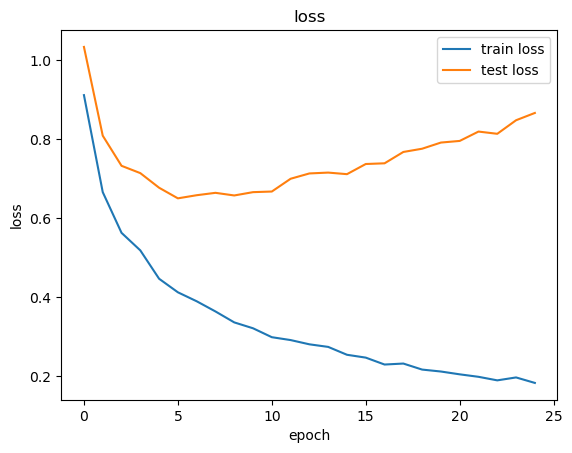

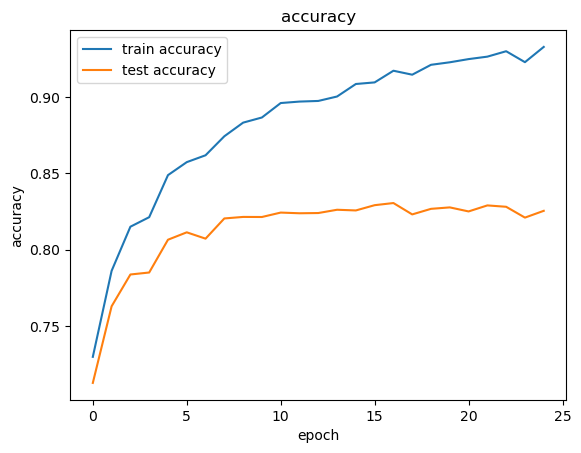

In [14]:
W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=leaky_ReLU, dactivation=dleaky_ReLU,
    layers=[784, 256, 10],
    eta=0.0001, num_epochs=25, batch_size=32, optimizer="rmsprop"
)

plt.figure()
plt.plot(loss_tr, label="train loss")
plt.plot(loss_te, label="test loss")
plt.legend()
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure()
plt.plot(acc_tr, label="train accuracy")
plt.plot(acc_te, label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()



Epoch 1/25 - acc_train=0.729 - acc_test=0.713
Epoch 2/25 - acc_train=0.787 - acc_test=0.763
Epoch 3/25 - acc_train=0.819 - acc_test=0.787
Epoch 4/25 - acc_train=0.822 - acc_test=0.786
Epoch 5/25 - acc_train=0.849 - acc_test=0.806
Epoch 6/25 - acc_train=0.857 - acc_test=0.811
Epoch 7/25 - acc_train=0.865 - acc_test=0.811
Epoch 8/25 - acc_train=0.876 - acc_test=0.821
Epoch 9/25 - acc_train=0.883 - acc_test=0.822
Epoch 10/25 - acc_train=0.884 - acc_test=0.819
Epoch 11/25 - acc_train=0.894 - acc_test=0.827
Epoch 12/25 - acc_train=0.896 - acc_test=0.826
Epoch 13/25 - acc_train=0.896 - acc_test=0.824
Epoch 14/25 - acc_train=0.897 - acc_test=0.825
Epoch 15/25 - acc_train=0.909 - acc_test=0.830
Epoch 16/25 - acc_train=0.911 - acc_test=0.827
Epoch 17/25 - acc_train=0.916 - acc_test=0.830
Epoch 18/25 - acc_train=0.916 - acc_test=0.829
Epoch 19/25 - acc_train=0.920 - acc_test=0.826
Epoch 20/25 - acc_train=0.925 - acc_test=0.831
Epoch 21/25 - acc_train=0.919 - acc_test=0.823
Epoch 22/25 - acc_trai

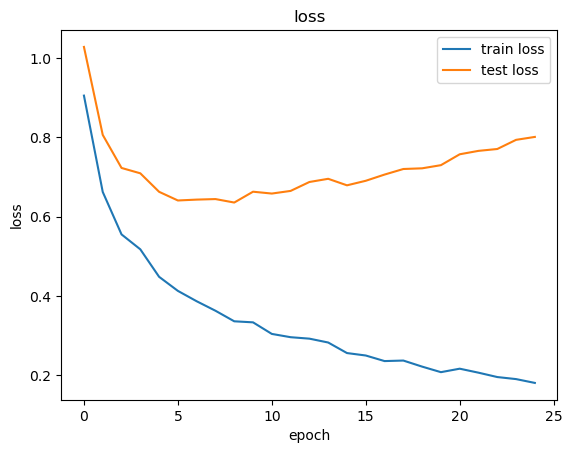

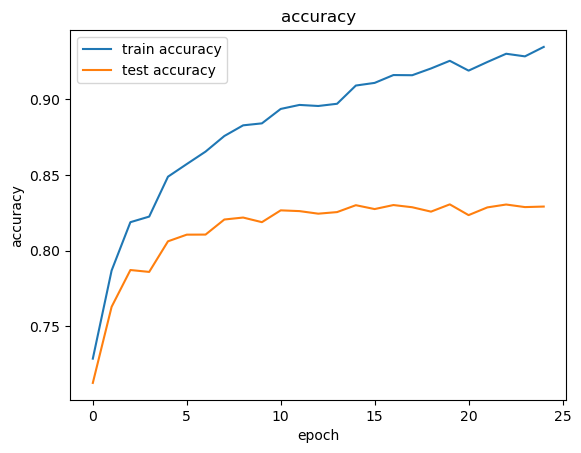

In [17]:
W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=leaky_ReLU, dactivation=dleaky_ReLU,
    layers=[784, 256, 10],
    eta=0.0001, num_epochs=25, batch_size=32, lam= 0.001, penalty="L2" , optimizer="rmsprop"
)

plt.figure()
plt.plot(loss_tr, label="train loss")
plt.plot(loss_te, label="test loss")
plt.legend()
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure()
plt.plot(acc_tr, label="train accuracy")
plt.plot(acc_te, label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

Epoch 1/25 - acc_train=0.726 - acc_test=0.706
Epoch 2/25 - acc_train=0.784 - acc_test=0.756
Epoch 3/25 - acc_train=0.815 - acc_test=0.785
Epoch 4/25 - acc_train=0.822 - acc_test=0.789
Epoch 5/25 - acc_train=0.846 - acc_test=0.812
Epoch 6/25 - acc_train=0.852 - acc_test=0.820
Epoch 7/25 - acc_train=0.860 - acc_test=0.826
Epoch 8/25 - acc_train=0.854 - acc_test=0.825
Epoch 9/25 - acc_train=0.843 - acc_test=0.812
Epoch 10/25 - acc_train=0.866 - acc_test=0.833
Epoch 11/25 - acc_train=0.866 - acc_test=0.838
Epoch 12/25 - acc_train=0.873 - acc_test=0.843
Epoch 13/25 - acc_train=0.870 - acc_test=0.839
Epoch 14/25 - acc_train=0.869 - acc_test=0.840
Epoch 15/25 - acc_train=0.880 - acc_test=0.847
Epoch 16/25 - acc_train=0.873 - acc_test=0.843
Epoch 17/25 - acc_train=0.882 - acc_test=0.848
Epoch 18/25 - acc_train=0.873 - acc_test=0.841
Epoch 19/25 - acc_train=0.884 - acc_test=0.848
Epoch 20/25 - acc_train=0.883 - acc_test=0.848
Epoch 21/25 - acc_train=0.868 - acc_test=0.836
Epoch 22/25 - acc_trai

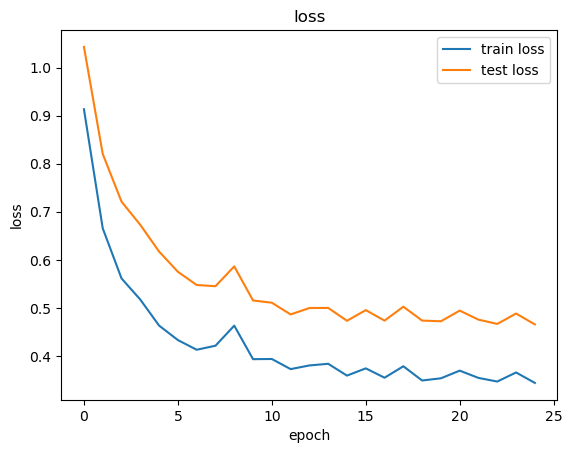

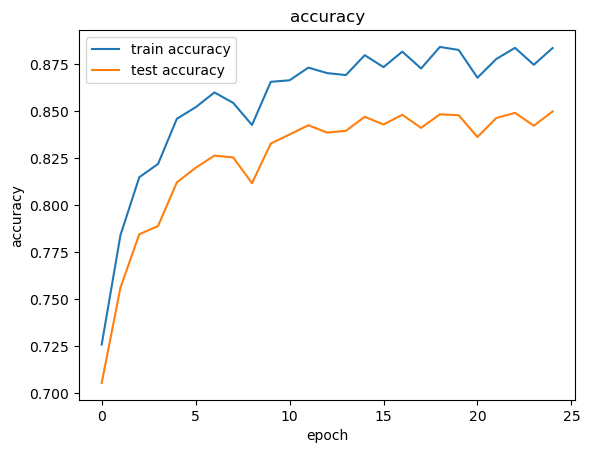

In [18]:
W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=leaky_ReLU, dactivation=dleaky_ReLU,
    layers=[784, 256, 10],
    eta=0.0001, num_epochs=25, batch_size=32, lam= 0.001, penalty="L1" , optimizer="rmsprop"
)

plt.figure()
plt.plot(loss_tr, label="train loss")
plt.plot(loss_te, label="test loss")
plt.legend()
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure()
plt.plot(acc_tr, label="train accuracy")
plt.plot(acc_te, label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [19]:
def predict(X):
    A = X
    for i in range(len(W)-1):
        A = leaky_ReLU(A @ W[i] + b[i])
    # last layer softmax:
    ZL = A @ W[-1] + b[-1]
    ZL -= np.max(ZL,axis=1,keepdims=True)
    expZ = np.exp(ZL)
    yhat = expZ / np.sum(expZ,axis=1,keepdims=True)
    return np.argmax(yhat,axis=1)

y_pred = predict(X_test)

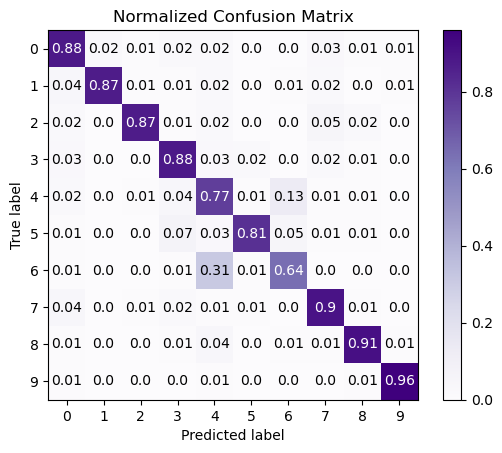

In [20]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, cmap=plt.cm.Purples)
plt.show()

In [23]:
W,b, loss_tr, loss_te, acc_tr, acc_te = sgd_FFNN_classifier(
    X_train, y_train, X_test, y_test,
    activation=leaky_ReLU, dactivation=dleaky_ReLU,
    layers=[784, 500, 256, 128, 64, 10],
    eta=0.0001, num_epochs=50, batch_size=32, lam= 0.001, penalty="L1" , optimizer="rmsprop"
)

Epoch 1/50 - acc_train=0.820 - acc_test=0.800
Epoch 2/50 - acc_train=0.839 - acc_test=0.823
Epoch 3/50 - acc_train=0.849 - acc_test=0.833
Epoch 4/50 - acc_train=0.851 - acc_test=0.838
Epoch 5/50 - acc_train=0.842 - acc_test=0.830
Epoch 6/50 - acc_train=0.846 - acc_test=0.832
Epoch 7/50 - acc_train=0.851 - acc_test=0.836
Epoch 8/50 - acc_train=0.849 - acc_test=0.834
Epoch 9/50 - acc_train=0.858 - acc_test=0.844
Epoch 10/50 - acc_train=0.851 - acc_test=0.837
Epoch 11/50 - acc_train=0.864 - acc_test=0.848
Epoch 12/50 - acc_train=0.864 - acc_test=0.848
Epoch 13/50 - acc_train=0.860 - acc_test=0.843
Epoch 14/50 - acc_train=0.867 - acc_test=0.850
Epoch 15/50 - acc_train=0.870 - acc_test=0.853
Epoch 16/50 - acc_train=0.872 - acc_test=0.854
Epoch 17/50 - acc_train=0.869 - acc_test=0.848
Epoch 18/50 - acc_train=0.866 - acc_test=0.846
Epoch 19/50 - acc_train=0.872 - acc_test=0.853
Epoch 20/50 - acc_train=0.866 - acc_test=0.845
Epoch 21/50 - acc_train=0.872 - acc_test=0.855
Epoch 22/50 - acc_trai

In [24]:
def predict(X):
    A = X
    for i in range(len(W)-1):
        A = leaky_ReLU(A @ W[i] + b[i])
    # last layer softmax:
    ZL = A @ W[-1] + b[-1]
    ZL -= np.max(ZL,axis=1,keepdims=True)
    expZ = np.exp(ZL)
    yhat = expZ / np.sum(expZ,axis=1,keepdims=True)
    return np.argmax(yhat,axis=1)

y_pred = predict(X_test)

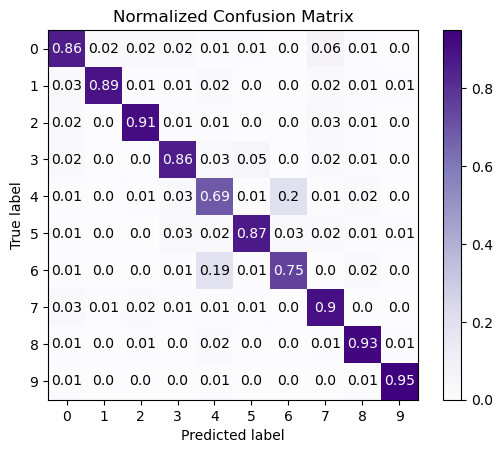

In [25]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, cmap=plt.cm.Purples)
plt.show() 